# Init

In [1]:
from utils import *
import math
p=11
ks=50
burst_path = '../images/bookshelf'
file_extension='*.jpg'
gaussian_ksize=31 # gaussian kernel size
burst=read_burst(burst_path, file_extension)

# Bursr Registration
reference source: `https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/`

In [2]:
burst=register_burst(burst)

In [ ]:
# cut the edge in order to remove black pixels
burst=burst[:,20:-20, 20:-20,:]
print(burst.shape)
plt.figure(figsize=(100,80))
for i in range(burst.shape[0]):
    plt.subplot(math.ceil(burst.shape[0]/3),3,i+1)
    plt.imshow(burst[i])
plt.show()

# FBA

In [3]:
# np.moveaxis: change the shape from (# of img, R, C, color) to (# of img, color, R, C)
spectrums=np.fft.fft2(np.moveaxis(burst, 3, 1))
# spectrum.shape = (# of img, color, R, C)

# get the spectrum of a blur kernel
shape=spectrums.shape[-2:]
sig=min(shape)/ks
blur_kernel_spectrum=get_gau_ker(gaussian_ksize, sig, shape)[1]

# average color channels
weight=np.mean(np.abs(spectrums), axis=1)

# pass through the gaussian filter
weight=weight*blur_kernel_spectrum

weight=np.power(weight, p)
weight/=np.sum(weight, axis=0)

# expand the shape of the weight from (# of img, R, C) to (# of img, color, R, C)
weight=np.repeat(np.expand_dims(weight, axis=1), 3, axis=1)

# restore image
spectrum_restored=np.sum(weight*spectrums, axis=0)
image_restored=np.fft.ifft2(spectrum_restored)

# change the shape from (color, R, C) to (R, C, color)
image_restored=np.moveaxis(image_restored, 0, 2)

# restore to uint8
image_restored=image_restored.real
print(f'# of pixels less than 0: {np.sum(image_restored<0)}\n# of pixels more than 255: {np.sum(image_restored>255)}')
image_restored=np.where(image_restored<0,0,image_restored)
image_restored=np.where(image_restored>255,255,image_restored).astype(np.uint8)


# of pixels less than 0: 942
# of pixels more than 255: 542632


In [4]:
t=np.fft.ifft2(spectrum_restored)
b=np.moveaxis(t.real, 0, 2)
b=b-b.min()
b=(b/b.max()*255).astype(np.uint8)

# Post processing

# save image

In [5]:
cv2.imwrite('result.png', image_restored)
cv2.imwrite('result2.png', b)
plt.figure(figsize=(100,80))
plt.subplot(2,1,1)
plt.imshow(image_restored)
plt.subplot(2,1,2)
plt.imshow(b)
plt.show()

True

# Fourier spectrums

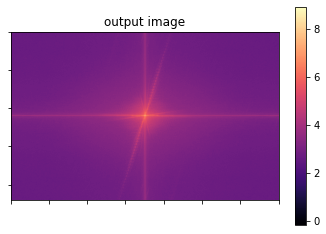

In [6]:
spectrum=np.fft.fftshift(np.fft.fft2(cv2.imread('../images/bookshelf/result/out_fba.jpg', 0)))

t=np.abs(spectrum)
plt.imshow(np.log10(np.abs(spectrum)),'magma')
plt.colorbar()
plt.xticks(visible = False)
plt.yticks(visible = False)
plt.title('output image')
plt.show()

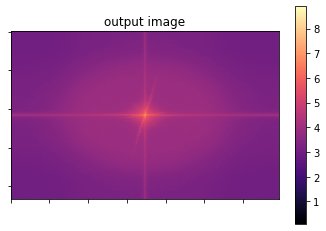

In [7]:
spectrum=np.fft.fftshift(np.fft.fft2(cv2.cvtColor(image_restored, cv2.COLOR_BGR2GRAY)))

t=np.abs(spectrum)
plt.imshow(np.log10(np.abs(spectrum)),'magma')
plt.colorbar()
plt.xticks(visible = False)
plt.yticks(visible = False)
plt.title('output image')
plt.show()